In [45]:
## remove the odd data from observationimport numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pandas import DataFrame,Series
from scipy import interpolate
import pickle

In [3]:
stationsname = ['A','B','C','D']

In [4]:
mat_file = 'sep_sta.mat'
station = loadmat(mat_file)
mat_file = '../data/stations/station.mat'
obs_station = loadmat(mat_file)

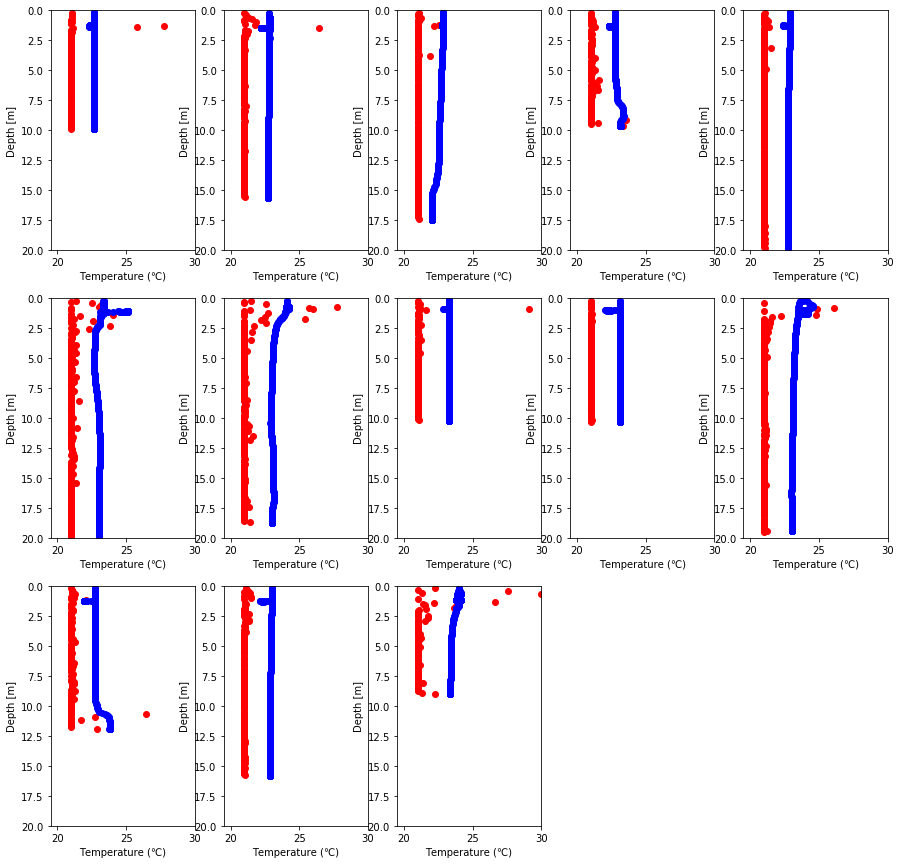

In [50]:
## select the std yuzhi
new_station = {}

for i in range(8,9):
    fig = plt.figure(figsize=(15, 15))
    weekname = 'week'+ str(i+1)
    for c, snames in enumerate(stationsname):
        ax = fig.add_subplot(3, 5, c+1)
        ## select only down cast
        down_id = np.where(station[snames][weekname][0][0]['depth'][0][0] == np.max(station[snames][weekname][0][0]['depth'][0][0]))
        down_id = down_id[0][0]
        temp = station[snames][weekname][0][0]['temp'][0][0][0:down_id]
        depth = station[snames][weekname][0][0]['depth'][0][0][0:down_id]
        ## create dataframe
        df = DataFrame.from_dict({"depth":depth[:,0],
               "depth_f":np.round(depth[:,0],1),
               "temp":temp[:,0]},orient='columns')
        
        ## delete nan
        df.dropna(axis=0,how='any') #drop all rows that have any NaN values
        
        ## group the temp with the 0.1m layer and calculate std
        grouped = df["temp"].groupby(df["depth_f"]) 
        temp_std = grouped.std(ddof=0)
        ax.scatter(temp_std.values*100+21,temp_std.index,color = 'red')
        
        ax.scatter(station[snames][weekname][0][0]['temp'][0][0][0:down_id],station[snames][weekname][0][0]['depth'][0][0][0:down_id],
                   color = 'blue') 
        ax.set_ylim(0, 20)
        #ax.set_ylabel('depth')
        ax.invert_yaxis()
        ax.set_xlim(19.5, 30)
        
        #ax.set_title(snames)
        ax.set_xlabel("Temperature ("+u'\u2103'+')')
        ax.set_ylabel("Depth [m]")
        #plt.show()
    #plt.close()

Same time different stations

In [52]:
new_station[snames]  = 1

In [53]:
jupingyuzhi = 0.005
new_station = {}
std_stdyuzhi = 0.01
fuzhuhanshuyuzhi = 0.01
fengcengzhi = 0.8

def panduan(x,F):
    if x['temp'].std(ddof=0)<=std_stdyuzhi:
        
        return 0*x['temp']
    else:
        
        juping = np.abs(x['temp'] - F(x['depth']))
        fanhuizhi = 0*x['temp']
        fanhuizhi[juping>jupingyuzhi] = 1
        #print(juping)
        return fanhuizhi




for i in range(16):
    #fig = plt.figure(figsize=(15, 15))
    weekname = 'week'+ str(i+1)
    new_station[weekname]  = {}
    for c, snames in enumerate(stationsname):
        #ax = fig.add_subplot(3, 5, c+1)
        ## select only down cast
        if (i==14 or i==15) and snames=='MB':
            temp = station[snames][weekname][0][0]['temp'][0][0][:]
            depth = station[snames][weekname][0][0]['depth'][0][0][:]
        else:
                
            down_id = np.where(station[snames][weekname][0][0]['depth'][0][0] == np.max(station[snames][weekname][0][0]['depth'][0][0]))
            down_id = down_id[0][0]
            temp = station[snames][weekname][0][0]['temp'][0][0][0:down_id]
            depth = station[snames][weekname][0][0]['depth'][0][0][0:down_id]
        ## create dataframe
        df = DataFrame({"depth":depth[:,0],
               "depth_f":np.round(depth[:,0]*fengcengzhi,1),
               "temp":temp[:,0]},index = list(np.arange(depth.shape[0])))
        
        ## delete nan
        df.dropna(axis=0,how='any') #drop all rows that have any NaN values
        #print(df)
        ## group the temp with the 0.1m layer and calculate std
        df['depth_id'] = df['depth_f']
        grouped = df["temp"].groupby(df["depth_f"]) 
 

       
        temp_std = grouped.std(ddof=0)
        #print(temp_std)
        
        ## remove the layer std > 0.04
        
        temp_mean = df.groupby('depth_f')['temp'].mean()
        fuzhuhanshu = temp_mean[temp_std<fuzhuhanshuyuzhi]
        ## 构造辅助函数
        vup = fuzhuhanshu[fuzhuhanshu.index.values.min()]
        vdown = fuzhuhanshu[fuzhuhanshu.index.values.max()]
        F=interpolate.interp1d(fuzhuhanshu.index.values,fuzhuhanshu.values,kind='linear',fill_value=(vup, vdown), bounds_error=False)
        
        ## 判断离散度较大层内与辅助函数相差为0.1的liufou值为1，否则为0
        #print(df.groupby('depth_f', group_keys = False).apply(lambda x : panduan(x,F)))
        df['liufou'] = df.groupby('depth_f', group_keys = False).apply(lambda x : panduan(x,F))
        
        new_station[weekname][snames] = {}
        new_station[weekname][snames]['depth'] = df[df['liufou']<0.5]['depth'].values[:]
        new_station[weekname][snames]['temp'] = df[df['liufou']<0.5]['temp'].values[:]
        
        
        
        
        
        

In [54]:
jupingyuzhi = 0.01
std_stdyuzhi = 0.03
fuzhuhanshuyuzhi = 0.03
fencengzhi = 1

def panduan(x,F):
    if x['temp'].std(ddof=0)<=std_stdyuzhi:
        
        return 0*x['temp']
    else:
        
        juping = np.abs(x['temp'] - F(x['depth']))
        fanhuizhi = 0*x['temp']
        fanhuizhi[juping>jupingyuzhi] = 1
        #print(juping)
        return fanhuizhi




for i in [1,5,10]:
    #fig = plt.figure(figsize=(15, 15))
    weekname = 'week'+ str(i+1)
    #new_station[weekname]  = {}
    for c, snames in enumerate(['A','B','C','D']):
        #ax = fig.add_subplot(3, 5, c+1)
        ## select only down cast
        if (i==14 or i==15) and snames=='MB':
            temp = station[snames][weekname][0][0]['temp'][0][0][:]
            depth = station[snames][weekname][0][0]['depth'][0][0][:]
        else:
                
            down_id = np.where(station[snames][weekname][0][0]['depth'][0][0] == np.max(station[snames][weekname][0][0]['depth'][0][0]))
            down_id = down_id[0][0]
            temp = station[snames][weekname][0][0]['temp'][0][0][0:down_id]
            depth = station[snames][weekname][0][0]['depth'][0][0][0:down_id]
        ## create dataframe
        df = DataFrame({"depth":depth[:,0],
               "depth_f":np.round(depth[:,0]*fencengzhi,1),
               "temp":temp[:,0]},index = list(np.arange(depth.shape[0])))
        
        ## delete nan
        df.dropna(axis=0,how='any') #drop all rows that have any NaN values
        #print(df)
        ## group the temp with the 0.1m layer and calculate std
        df['depth_id'] = df['depth_f']
        grouped = df["temp"].groupby(df["depth_f"]) 
 

       
        temp_std = grouped.std(ddof=0)
        #print(temp_std)
        
        ## remove the layer std > 0.04
        
        temp_mean = df.groupby('depth_f')['temp'].mean()
        fuzhuhanshu = temp_mean[temp_std<fuzhuhanshuyuzhi]
        ## 构造辅助函数
        vup = fuzhuhanshu[fuzhuhanshu.index.values.min()]
        vdown = fuzhuhanshu[fuzhuhanshu.index.values.max()]
        F=interpolate.interp1d(fuzhuhanshu.index.values,fuzhuhanshu.values,kind='linear',fill_value=(vup, vdown), bounds_error=False)
        
        ## 判断离散度较大层内与辅助函数相差为0.1的liufou值为1，否则为0
        #print(df.groupby('depth_f', group_keys = False).apply(lambda x : panduan(x,F)))
        df['liufou'] = df.groupby('depth_f', group_keys = False).apply(lambda x : panduan(x,F))
        
        #new_station[weekname][snames] = {}
        new_station[weekname][snames]['depth'] = df[df['liufou']<0.5]['depth'].values[:]
        new_station[weekname][snames]['temp'] = df[df['liufou']<0.5]['temp'].values[:]
        
        
        
        
        
        

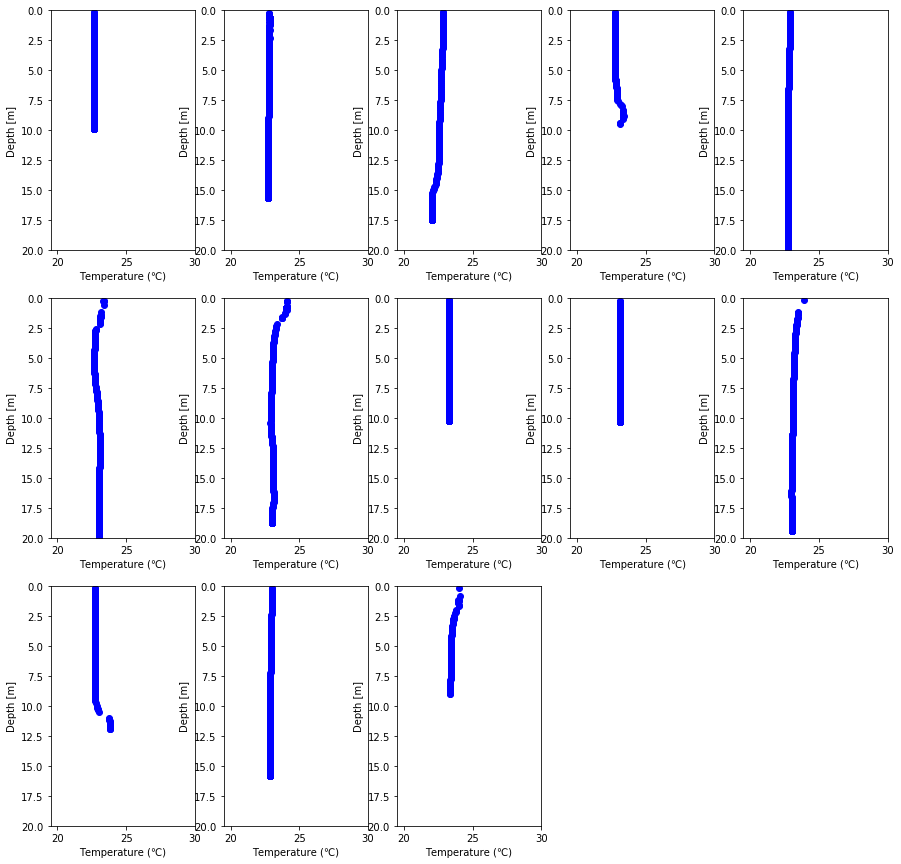

In [55]:
savepath = '../pics/profile/quqiyizhi/'
for i in range(8,9):
    fig = plt.figure(figsize=(15, 15))  # size in inches
    #plt.subplots_adjust(hspace=0.01)
    weekname = 'week'+ str(i+1)
    for c, snames in enumerate(stationsname):
        ax = fig.add_subplot(3, 5, c+1)

        #ax.plot(obstd[snames][:,c], (depth[c]+obszeta[snames][0,i])*siglay,color = 'red')
        ax.scatter(new_station[weekname][snames]['temp'],new_station[weekname][snames]['depth'],
                   color = 'blue')
        ax.set_ylim(0, 20)
        #ax.set_ylabel('depth')
        ax.invert_yaxis()
        offset = 0.01
        #x1, x2 = ax.get_xlim()[0] - offset, ax.get_xlim()[1] + offset
        ax.set_xlim(19.5, 30)
        
     #   ax.set_title(snames)
        ax.set_xlabel("Temperature ("+u'\u2103'+')')
        ax.set_ylabel("Depth [m]")
    #plt.suptitle(weekname,fontsize = 20)
    plt.savefig(savepath+weekname+'.png',dpi=200)
    #plt.close()

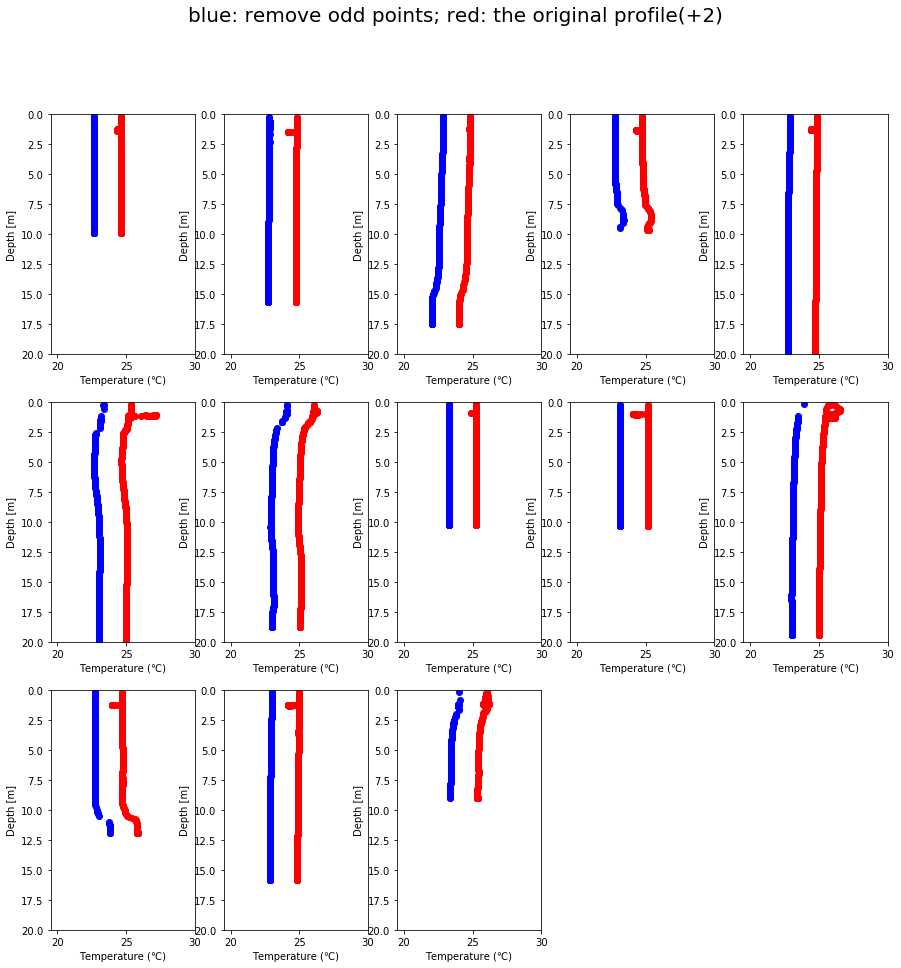

In [57]:
savepath = '../pics/profile/quqiyizhi/duibi/'
for i in range(8,9):
    fig = plt.figure(figsize=(15, 15))  # size in inches
    #plt.subplots_adjust(hspace=0.01)
    weekname = 'week'+ str(i+1)
    for c, snames in enumerate(stationsname):
        ax = fig.add_subplot(3, 5, c+1)

        #ax.plot(obstd[snames][:,c], (depth[c]+obszeta[snames][0,i])*siglay,color = 'red')
        ax.scatter(new_station[weekname][snames]['temp'],new_station[weekname][snames]['depth'],
                   color = 'blue')
        down_id = np.where(station[snames][weekname][0][0]['depth'][0][0] == np.max(station[snames][weekname][0][0]['depth'][0][0]))
        down_id = down_id[0][0]
        
        ax.scatter(station[snames][weekname][0][0]['temp'][0][0][0:down_id]+2,station[snames][weekname][0][0]['depth'][0][0][0:down_id],
                   color = 'red')
        ax.set_ylim(0, 20)
        #ax.set_ylabel('depth')
        ax.invert_yaxis()
        offset = 0.01
        #x1, x2 = ax.get_xlim()[0] - offset, ax.get_xlim()[1] + offset
        ax.set_xlim(19.5, 30)
        
        #ax.set_title(snames)
        ax.set_xlabel("Temperature ("+u'\u2103'+')')
        ax.set_ylabel("Depth [m]")
    plt.suptitle('blue: remove odd points; red: the original profile(+2)',fontsize = 20)
    plt.savefig(savepath+weekname+'.png',dpi=200)
    #plt.close()

In [47]:
# save the data
output = open('new_obs_station.pkl','wb')
pickle.dump(new_station,output)
output.close()